cuda
Epoch 1: Train Loss: 0.6857, Train Accuracy: 74.48%, Test Loss: 0.6743, Test Accuracy: 75.07%
Epoch 2: Train Loss: 0.4472, Train Accuracy: 83.63%, Test Loss: 0.3882, Test Accuracy: 86.21%
Epoch 3: Train Loss: 0.3946, Train Accuracy: 85.52%, Test Loss: 0.3384, Test Accuracy: 87.52%
Epoch 4: Train Loss: 0.3682, Train Accuracy: 86.67%, Test Loss: 0.3177, Test Accuracy: 87.64%
Epoch 5: Train Loss: 0.3504, Train Accuracy: 87.27%, Test Loss: 0.3179, Test Accuracy: 88.36%
Epoch 6: Train Loss: 0.3364, Train Accuracy: 87.68%, Test Loss: 0.2830, Test Accuracy: 89.63%
Epoch 7: Train Loss: 0.3269, Train Accuracy: 88.10%, Test Loss: 0.2838, Test Accuracy: 90.00%
Epoch 8: Train Loss: 0.3121, Train Accuracy: 88.53%, Test Loss: 0.2575, Test Accuracy: 90.74%
Epoch 9: Train Loss: 0.3058, Train Accuracy: 88.70%, Test Loss: 0.2592, Test Accuracy: 90.36%
Epoch 10: Train Loss: 0.2983, Train Accuracy: 89.03%, Test Loss: 0.2699, Test Accuracy: 90.53%
Epoch 11: Train Loss: 0.2454, Train Accuracy: 91.04%, 

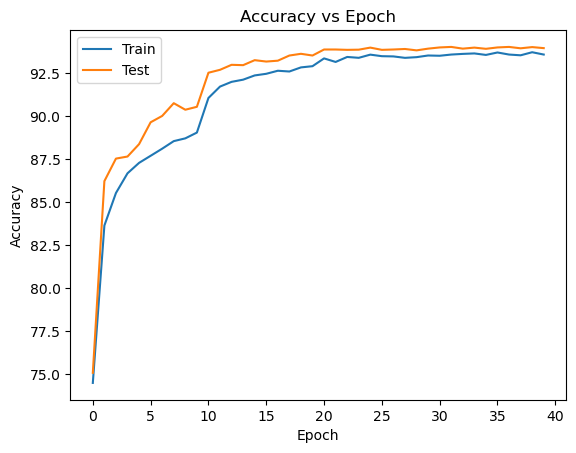

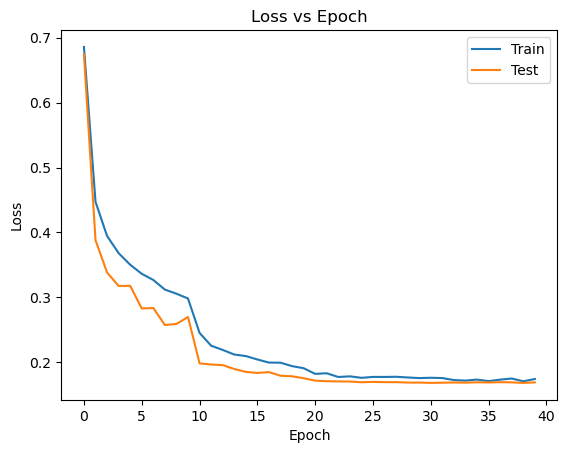

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34
import matplotlib.pyplot as plt
import os

# 定义训练函数
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy



transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    # transforms.RandomResizedCrop(28),
    # transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
    transforms.RandomErasing()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,))
])
train_dataset = datasets.FashionMNIST(root='./data/', download=False, train=True, transform=transform_train)
test_dataset = datasets.FashionMNIST(root='./data/', download=False, train=False, transform=transform_test)
# 定义模型
model = resnet34(weights=None)  # 加载预训练模型
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_batch_size = 128
test_batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=8)
model = model.to(device)
model = torch.nn.DataParallel(model).cuda() # 多GPU并行计算
train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

for epoch in range(40):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
    scheduler.step() # 更新学习率
    test_loss, test_accuracy = test(model, device, test_loader, criterion)

    print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
        epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))
    
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints/')
    torch.save(model.state_dict(), './checkpoints/ResNet-epo{}-acc{}.ckpt'.format(epoch+1,test_accuracy))

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

# 绘制精度曲线
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

# 绘制损失曲线
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

